# Generalized Tophat shift approximations


Accounting for cross terms, higher order shift approximations can be generalized up to shift in order $k$ by combining expansions:\\


\begin{equation}
	\sum_{B=0}^{\lfloor{k/2}\rfloor}
	\sum_{A=0}^{k-2B}
\lbrace
	[
		\frac{1}{B!}
		(-\frac{a^2}{w^2})^B
	]
	[
		\frac{1}{A!}
		(-\frac{2ax}{w^2})^A
	]
\left[
{n \choose M}
(\frac{2ae^{i\Psi}}{w\sqrt{n}})^M
\right]
u_{n-M,m}		
\rbrace
\end{equation}

where

\begin{equation}
	M \equiv k-(A+2B)
\end{equation}

In [3]:
import PauLisa as pl, PL_Plot as plplt,plback as plb, Tophat_integration_AW as th, numpy as np, matplotlib.pyplot as plt, cmath as cm

from numpy import pi as pi
from numpy import angle
#from numpy import sqrt as sqrt
from scipy.special import erf as erf
import mpmath as mp
import scipy.io

from math import pi, log, exp, sin, cos, atan, e, radians, degrees
from scipy.special import gamma as gamma
from scipy.special import erf as erf
from scipy.special import comb

from math import factorial as fac
import cmath
from cmath import sqrt as sqrt
import numpy as np

from time import process_time

inf=np.inf

import pandas as pd
from pprint import pprint

import queue


## Tophat coeffients from AW

In [4]:
mat = scipy.io.loadmat('Top_hat_for_paul.mat')
coef=mat['coeftop'].ravel()

def N_f(A):
    
    res = np.floor((np.sqrt(8*A+1)-1)/2)
    
    #res = (np.sqrt(9+8*A)-3)/2
    return(res)

def m(N,A):
    res = (N+1)*(N+2)/2 - (A+1)
    return(res)

#def n(N,A):
#    m= (N+1)*(N+2)/2 - (A+1)
#    res = N-m
#    return(res)
def n(N,A):
    res = A - (N*(N+1)/2)
    return(res)

NumberModes = int(len(coef))
listModesN = [None] * NumberModes
listModesM = [None] * NumberModes
listModesC = [None] * NumberModes

area = pi*1e-3**2

#for i in range(len(coef)):
#    A=i
#    N= N_f(A)
#
#    if (m(N,A)%2 == 0) & (n(N,A)%2 == 0):
#        print(coef[A], '\t\t\t' , m(N,A), ',' , n(N,A))

for i in range(NumberModes):
    A=i
    N= N_f(A)
    listModesN[i] = int(m(N,A))
    listModesM[i] = int(n(N,A))
    listModesC[i] = coef[i]/sqrt(area)
    
    

In [31]:
modes_0 = plb.modes((0,0,1))
modes_2 = plb.modes((2,0,1),(3,0,1))
modes = pl.create_modes(listModesM,listModesN,listModesC,NumberModes)

N=28 # mode order
modes_N= pl.create_modes_orderN(listModesM,listModesN,listModesC,NumberModes,N)

a= 10e-6
alpha = 100e-6
plane = pl.Plane(-2e-3,2e-3,300,-2e-3,2e-3,300)

## Expansion function

In [63]:
# Apply general mode scatter formulas for x-dependence (uni-directional offset coord.), RETURN new modes(on-axis)
# Up to approximation order k
def shift(z,params,a,alpha,modes,k):
    
    #get params
    K = params.getK()
    w0 = params.getW0()
    zr = params.getZr()
    w_z = pl.w(z,params)
    gouy = pl.gouy_phase(z,params) 
    
    #get shape to iterate through modes
    rows = len(modes)
    cols = len(modes[0])
    
    number_modes = rows*cols
    
    #build new modes (up to 2 orders larger for quad. dep.)
    new_modes = [[0 for m in range(cols+k+1)] for n in range(rows+k+1)]
    
    for i in range(rows):
        for j in range(cols):
            new_modes[i][j] = modes[i][j]
    
    A_sub = 0
    M_sub = 0
    
    # iterate all modes
    for n in range(rows):
        for m in range(cols):            
            #ignore zero coeff.
            if (modes[n][m]!=0):
                c_nm = modes[n][m]
                for B in range( int( (k) +1 ) ): #+1 for inclusive
                    for A in range( int((k-2*B) +1)):
                        sum_B = (
                            (1/fac(B))*
                            (-a**2/w_z**2)**B
                        )
                        
                        sum_A = (
                            (1/fac(A))*
                            (-2*a/w_z**2)**A
                        )
                        
                        M = (k-A+2*B)
                        
                        if(n>0):
                            sum_M = (
                                (comb(n,M)
                                * (2*a*e**( (1j)*gouy))/(w_z*sqrt(n))
                                )**M
                            )
                        
                        else:
                            sum_M = 1
                        #print(A,M)    
                        #overall coupling result
                        
                        coupling = (sum_B*sum_A*sum_M)
                        
                        #no coupling into other modes
                        if (A ==0 and M==0):
                            new_modes[n][m]+=c_nm*coupling
                                
                        # couple into modes (n-M, and X**A)   
                        # n-M determines start, need n+1,n-1 for each x    
                        else:
                            M_sub = M
                            A_sub = A
                            n_start = n-M
                            
                            #print('a',A)
                            
                            q = queue.Queue()
                            #queue with n and coeff.
                            q.put([n_start,new_modes[n][m]])
                            temp = queue.Queue()
                            
                            while(A_sub!=0):
                                work_modes = [[0 for m in range(cols+k+1)] for n in range(rows+k+1)]
                                while(not q.empty()):
                                    #for each (n) in the q, +/- 1 append with a coupling
                                    f,g = q.get()
                                    g += work_modes[f][m]
                                    
                                    
                                    #n+1 (working coeff. * coupling * scatter coupling)
                                    total_coup = g*coupling*x_plus_1(w0,z,zr,f)
                                    new_modes[int(f+1)][m] += total_coup
                                    work_modes[f+1][m] +=total_coup
                                    
                                    if(f+1<rows):
                                        temp.put([f+1,modes[f+1][m]])
                                    
                                    #n-1
                                    if(f>0):
                                        total_coup = g*coupling*x_minus_1(w0,z,zr,f)
                                        new_modes[f-1][m]+= total_coup
                                        temp.put([f-1,modes[f-1][m]])
                                        work_modes[f-1][m] +=total_coup

                                if(q.empty()):
                                    
                                    A_sub-=1
                                    #q emptied, decrement A, refill q with temp
                                    while(not temp.empty()):
                                        #print('i')
                                        q.put(temp.get())

    return(new_modes)

#x dep
def x_plus_1(w0,z,zr,n):    
    factor = (w0/2)*( ( 1-(1j)*(z/zr) )*np.sqrt(n+1))
    return(factor)

#x dep
def x_minus_1(w0,z,zr,n):
    factor = (w0/2)*( np.sqrt(n)*(1+(1j)*(z/zr)) )
    return(factor)

In [64]:
z=0
params = pl.Params(1064e-9,0.00023067,0)
plane=pl.Plane(-2e-3,2e-3,200,-2e-3,2e-3,200)

a = 10e-6
alpha = 0
k = 1
sc_modes = shift(z,params,a,alpha,modes_2,k)

In [65]:
pl.show_modes(sc_modes)

n\m [0, 1, 2]
0   [0, 0, 0]
1   [(-0.061308950551571297+0j), 0, 0]
2   [(0.930550358368165+0j), 0, 0]
3   [(0.9249121772415625+0j), 0, 0]
4   [(-0.08019353858252591+0j), 0, 0]
5   [0, 0, 0]


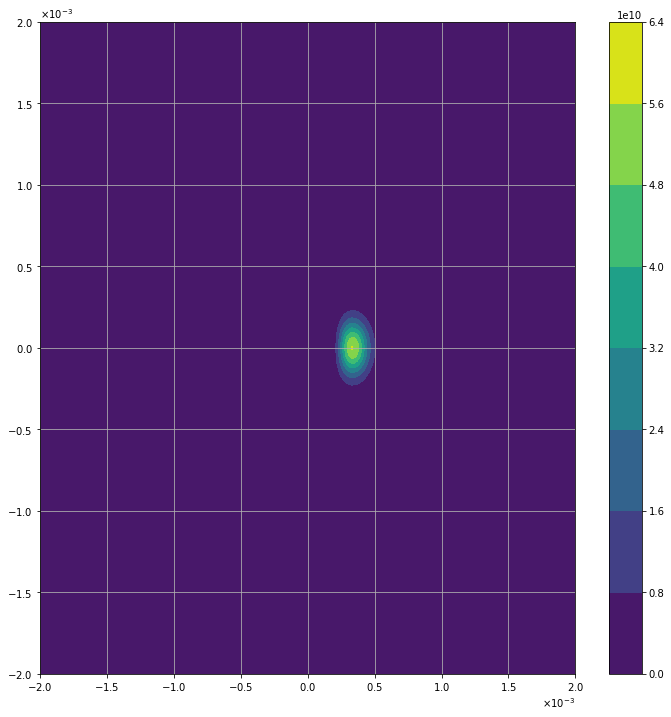

In [43]:

f2 = pl.calculate(params,plane,sc_modes,z)
fig, ax = plt.subplots(figsize=(12, 12))
cs = plt.contourf(f2.plane.getX(), f2.plane.getY(), abs(f2.getAmp() ** 2))

ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0), useMathText=True)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0), useMathText=True)

cbar = fig.colorbar(cs)

plt.grid()

In [ ]:
2*1e-3/